## Define the inception module function and the google net function. the google net function will use the inception module function inorder to construct the different (9) inception modules needed for our Googlenet


In [29]:
import tensorflow as tf


def inception_module(
    input_tensor,
    filter_bank1x1,
    filter_bank3x3_reduce,
    filter_bank3x3,
    filter_bank5x5_reduce,
    filter_bank5x5,
    pool_proj,
):
    """
    Implements an Inception module.

    Args:
        input_tensor: Input tensor.
        filter_bank1x1: Number of filters for 1x1 convolution.
        filter_bank3x3_reduce: Number of filters for 3x3 convolution reduction.
        filter_bank3x3: Number of filters for 3x3 convolution.
        filter_bank5x5_reduce: Number of filters for 5x5 convolution reduction.
        filter_bank5x5: Number of filters for 5x5 convolution.
        pool_proj: Number of filters for pooling projection.

    Returns:
        Output tensor from the Inception module.
    """

    # 1x1 convolution
    conv1x1 = tf.keras.layers.Conv2D(
        filter_bank1x1, (1, 1), padding="same", activation="relu"
    )(input_tensor)

    # 3x3 convolution
    conv3x3_reduce = tf.keras.layers.Conv2D(
        filter_bank3x3_reduce, (1, 1), padding="same", activation="relu"
    )(input_tensor)
    conv3x3 = tf.keras.layers.Conv2D(
        filter_bank3x3, (3, 3), padding="same", activation="relu"
    )(conv3x3_reduce)

    # 5x5 convolution
    conv5x5_reduce = tf.keras.layers.Conv2D(
        filter_bank5x5_reduce, (1, 1), padding="same", activation="relu"
    )(input_tensor)
    conv5x5 = tf.keras.layers.Conv2D(
        filter_bank5x5, (5, 5), padding="same", activation="relu"
    )(conv5x5_reduce)

    # Pooling and projection
    pool = tf.keras.layers.MaxPooling2D((3, 3), strides=(1, 1), padding="same")(
        input_tensor
    )
    pool_final = tf.keras.layers.Conv2D(
        pool_proj, (1, 1), padding="same", activation="relu"
    )(pool)

    # Concatenate the outputs
    output = tf.keras.layers.Concatenate()([conv1x1, conv3x3, conv5x5, pool_final])

    return output


def google_net(input_shape, num_classes=1000):
    """
    Creates a GoogleNet (Inception-v1) model.

    Args:
        input_shape: Shape of the input images.
        num_classes: Number of classes in the dataset.
    Returns:
        GoogleNet model.
    """

    # Input layer
    inputs = tf.keras.layers.Input(input_shape)

    # Convolutional layers
    conv1 = tf.keras.layers.Conv2D(
        64, (7, 7), strides=(2, 2), padding="same", activation="relu"
    )(inputs)
    pool1 = tf.keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding="same")(conv1)
    conv2 = tf.keras.layers.Conv2D(192, (3, 3), padding="same", activation="relu")(
        pool1
    )
    pool2 = tf.keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding="same")(conv2)

    # Inception modules
    inception_3a = inception_module(pool2, 64, 96, 128, 16, 32, 32)
    inception_3b = inception_module(inception_3a, 128, 128, 192, 32, 64, 64)
    pool3 = tf.keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding="same")(
        inception_3b
    )
    inception_4a = inception_module(pool3, 192, 96, 128, 16, 32, 32)
    inception_4b = inception_module(inception_4a, 160, 128, 192, 32, 64, 64)
    inception_4c = inception_module(inception_4b, 160, 128, 192, 32, 64, 64)
    pool4 = tf.keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding="same")(
        inception_4c
    )
    inception_5a = inception_module(pool4, 192, 96, 128, 16, 32, 32)
    inception_5b = inception_module(inception_5a, 192, 128, 192, 32, 64, 64)

    # Average pooling and fully connected layers
    avg_pool = tf.keras.layers.GlobalAveragePooling2D()(inception_5b)
    fc1 = tf.keras.layers.Dense(1024, activation="relu")(avg_pool)

    # final decision layer with softmax activation for the number of classes given as input
    fc2 = tf.keras.layers.Dense(num_classes, activation="softmax")(fc1)

    # Create the model
    model = tf.keras.models.Model(inputs, fc2)
    model.compile(
        optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
    )

    return model


# Example usage
model = google_net(input_shape=(224, 224, 3))
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_176 (Conv2D) │ (None, 112, 112,  │      9,472 │ input_layer_5[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_44    │ (None, 56, 56,    │          0 │ conv2d_176[0][0]  │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_177 (Conv2D) │ (None, 56, 56,    │    110,784 │ max_pooling2d_44… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_45    │ (None, 28, 28,    │          0 │ conv2d_177[0][0]  │
│ (MaxPooling2D)      │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_179 (Conv2D) │ (None, 28, 28,    │     18,528 │ max_pooling2d_45… │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_181 (Conv2D) │ (None, 28, 28,    │      3,088 │ max_pooling2d_45… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_46    │ (None, 28, 28,    │          0 │ max_pooling2d_45… │
│ (MaxPooling2D)      │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_178 (Conv2D) │ (None, 28, 28,    │     12,352 │ max_pooling2d_45… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_180 (Conv2D) │ (None, 28, 28,    │    110,720 │ conv2d_179[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_182 (Conv2D) │ (None, 28, 28,    │     12,832 │ conv2d_181[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_183 (Conv2D) │ (None, 28, 28,    │      6,176 │ max_pooling2d_46… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_28      │ (None, 28, 28,    │          0 │ conv2d_178[0][0], │
│ (Concatenate)       │ 256)              │            │ conv2d_180[0][0], │
│                     │                   │            │ conv2d_182[0][0], │
│                     │                   │            │ conv2d_183[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_185 (Conv2D) │ (None, 28, 28,    │     32,896 │ concatenate_28[0… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_187 (Conv2D) │ (None, 28, 28,    │      8,224 │ concatenate_28[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_47    │ (None, 28, 28,    │          0 │ concatenate_28[0… │
│ (MaxPooling2D)      │ 256)              │            │                 

 Total params: 4,067,576 (15.52 MB)

 Trainable params: 4,067,576 (15.52 MB)

 Non-trainable params: 0 (0.00 B)

# define sequential model for comparison

## use previously defined function for the sequential model, using relu as activation, and adam as optimizer because these two combination gave the best result from previous experiments


In [27]:
# normal sequential model. use best one from comparisons made
# Define the model
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam


def build_model():
    model = Sequential(
        [
            # xtrain shape (48000, 784)
            Dense(
                128, input_shape=(784,), activation="relu"
            ),  # Input layer with ReLU activation
            # add 3 hidden layers
            Dense(64, activation="relu"),  # Hidden layer with ReLU activation
            Dense(64, activation="relu"),  # Hidden layer with ReLU activation
            Dense(64, activation="relu"),  # Hidden layer with ReLU activation
            Dense(10, activation="softmax"),  # Output layer with softmax activation
        ]
    )
    return model


# part III Algorithm III = Adam
sequential_model = build_model()
optimizer = Adam()
sequential_model.compile(optimizer=optimizer, loss="categorical_crossentropy")
sequential_model.summary()

c:\Users\yared\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 117,706 (459.79 KB)

 Trainable params: 117,706 (459.79 KB)

 Non-trainable params: 0 (0.00 B)

## Import and prepare the dataset for both the models.

## the sequential model will accept flattened input, and we'll keep the dimensions of the input data to feed to the googlenet model. cause CNN's are cool like that


In [28]:
# import mnist
from tensorflow.keras.datasets import mnist
import tensorflow as tf

# Load and process the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

print("original shapes", x_train.shape, y_train.shape, x_test.shape, y_test.shape)

# Normalize the data
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

# Reshape the data for sequential model
x_train_seq = x_train.reshape((x_train.shape[0], -1))
x_test_seq = x_test.reshape((x_test.shape[0], -1))

# Convert class vectors to binary class matrices
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)
print(
    "reshaped shapes for sequential",
    x_train_seq.shape,
    y_train.shape,
    x_test_seq.shape,
    y_test.shape,
)

original shapes (60000, 28, 28) (60000,) (10000, 28, 28) (10000,)
reshaped shapes for sequential (60000, 784) (60000, 10) (10000, 784) (10000, 10)


# Train both models


In [30]:
# Train the model
google_model = google_net(input_shape=(28, 28, 1), num_classes=10)

google_history = google_model.fit(
    x_train, y_train, validation_data=(x_test, y_test), epochs=10
)


sequential_history = sequential_model.fit(
    x_train_seq, y_train, batch_size=64, epochs=10, validation_split=0.1
)

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 271s 135ms/step - accuracy: 0.5603 - loss: 1.1296 - val_accuracy: 0.9762 - val_loss: 0.0861
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 265s 141ms/step - accuracy: 0.9727 - loss: 0.1073 - val_accuracy: 0.9789 - val_loss: 0.0840
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 328s 144ms/step - accuracy: 0.9807 - loss: 0.0796 - val_accuracy: 0.9823 - val_loss: 0.0794
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 246s 131ms/step - accuracy: 0.9820 - loss: 0.0760 - val_accuracy: 0.9860 - val_loss: 0.0609
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 292s 147ms/step - accuracy: 0.9863 - loss: 0.0564 - val_accuracy: 0.9864 - val_loss: 0.0860
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 260s 138ms/step - accuracy: 0.9876 - loss: 0.0525 - val_accuracy: 0.9782 - val_loss: 0.0966
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 236s 126ms/step - accuracy: 0.9870 - loss: 0.0517 - val_accuracy: 0.9899 - val_loss: 0.0430
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 309s 150ms/step - ac

# graph their hisotry results for comparison and validation


{'loss': [0.3051758110523224, 0.12029276043176651, 0.08488421142101288, 0.06732229143381119, 0.054121632128953934, 0.04510508477687836, 0.04009074717760086, 0.0317293219268322, 0.028408687561750412, 0.027196601033210754], 'val_loss': [0.10903856158256531, 0.09821587800979614, 0.08495849370956421, 0.09434038400650024, 0.0893963947892189, 0.07780798524618149, 0.083589106798172, 0.08536986261606216, 0.10910344123840332, 0.09025193005800247]}


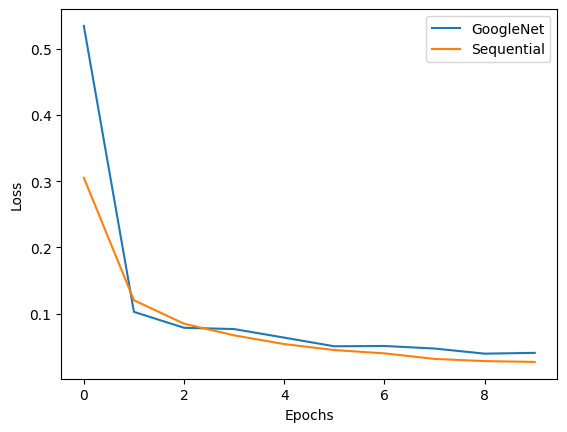

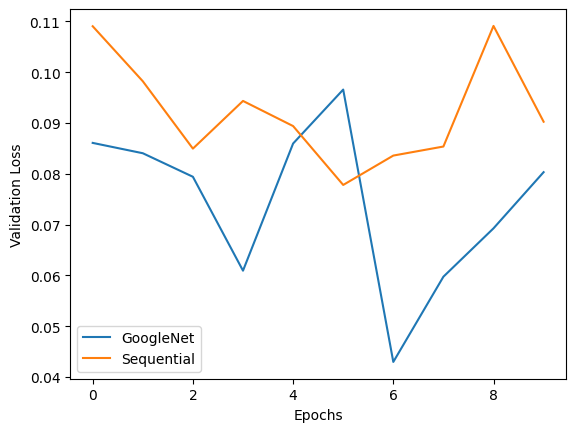

In [37]:
# plot the training and validattion history for both models
import matplotlib.pyplot as plt

print(sequential_history.history)
plt.plot(google_history.history["loss"], label="GoogleNet")
plt.plot(sequential_history.history["loss"], label="Sequential")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.plot(google_history.history["val_loss"], label="GoogleNet")
plt.plot(sequential_history.history["val_loss"], label="Sequential")
plt.xlabel("Epochs")
plt.ylabel("Validation Loss")
plt.legend()
plt.show()

### an unexpected graph result. final result seems to favor the sequential densely connected model, but as u can see for generalizing purposes the googlenet beats the sequential at almost every point of the validation loss


### perhaps this happend because our dataset is a bit too small for the google net. the better dataset would have been the cifar10 dataset, but their website isn't loading the data for me when trying to download. ( both using browser and import from keras it seems to be timing out) once it starts working I will retest and hopefully get ready for the presentation with results of both datasets
